In [1]:
import sys
sys.path.append('..')

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pandas as pd
import graph_tool as gt
from graph_tool import centrality, inference
from tqdm import tqdm
from operator import itemgetter
from functools import reduce
import itertools
import networkx as nx
#from py3plex.core import multinet
#from py3plex.core import random_generators

import MuxVizPy as mxp

import gseapy as gp

import warnings
warnings.filterwarnings("ignore")


#set.seed(1)

# input data settings
NEIGH_ORDER = 1 # or 0, order of nerighbors, 0 only connected proteins, 1 also first neighbors
CUT_THR = 0.7   # don't change this one

target_folder = "../Data/Virus_data_Enriched_"+str(CUT_THR)+"_Neigh_"+str(NEIGH_ORDER)+"/"

# multilayer settings
layerCouplingStrength = 1
networkOfLayersType = "categorical" ## = all to all

#virus metadata
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

#function to create list of n_iter combination of nonco virus indexes with a fixed random seed for repitibility
def SamplingForNoco(n_iter, start=0, group_dim=8):
    np.random.seed(1234)
    nonco_cond = np.where(np.all([np.array(virus_metadata["virus"]!="Human_SARS_coronavirus_2"),
                                  np.array(virus_metadata["neigh_order"]==NEIGH_ORDER), 
                                  np.array(virus_metadata["isOncogenic"]==False)],
                                  axis=0))
    
    nonco_sampling = np.array([np.random.choice(nonco_cond[0], group_dim, replace=False) for i in range(n_iter+start)])
    
    return nonco_sampling[start:(n_iter+start)]

In [4]:
mxp.build.get_node_tensor_from_network_list(net.g_list)

[<3919x3919 sparse matrix of type '<class 'numpy.float64'>'
 	with 115256 stored elements in Compressed Sparse Row format>,
 <3919x3919 sparse matrix of type '<class 'numpy.float64'>'
 	with 15212 stored elements in Compressed Sparse Row format>,
 <3919x3919 sparse matrix of type '<class 'numpy.float64'>'
 	with 332946 stored elements in Compressed Sparse Row format>,
 <3919x3919 sparse matrix of type '<class 'numpy.float64'>'
 	with 27270 stored elements in Compressed Sparse Row format>]

In [5]:
mxp.build.get_aggregate_network(mxp.build.get_node_tensor_from_network_list(net.g_list))

<Graph object, undirected, with 3919 vertices and 409084 edges, at 0x7fbc8f64c820>

In [2]:
alex_df = pd.read_csv("../Data/Alexis_things/Multilayer.edges", sep=" ")

In [233]:
def exctract_nets_from_extended_edgelist(dfEdges, Layers, Nodes):
    #Nodes = np.unique(dfEdges[["NodeIN","NodeOUT"]]).shape[0]
    #Layers = np.unique(dfEdges[["LayerIN","LayerOUT"]]).shape[0]
    g_list=[]
    for i in range(Layers):
        filt_edges = dfEdges[np.all([dfEdges["LayerIN"]==i, dfEdges["LayerOUT"]==i], axis=0)]
        tmp_multi = filt_edges.reset_index()[["NodeIN", "NodeOUT"]]
        tmp_multi = tmp_multi.rename({"NodeIN":"source", "NodeOUT":"target"}, axis=1)
        g=gt.Graph(directed=False)
        g.add_edge_list(tmp_multi.values)
        g.add_vertex(Nodes-g.num_vertices())
        g_list.append(g)
    return g_list

In [243]:
df_edg = pd.DataFrame({"NodeIN":np.random.randint(0,40,100),
                       "NodeOUT":np.random.randint(0,40,100),
                       "LayerIN":np.random.randint(0,4,100),
                       "LayerOUT":np.random.randint(0,4,100),})

In [244]:
nets = exctract_nets_from_extended_edgelist(df_edg, 4,40)

In [245]:
positions = gt.draw.sfdp_layout(nets[0]).get_2d_array([0,1])

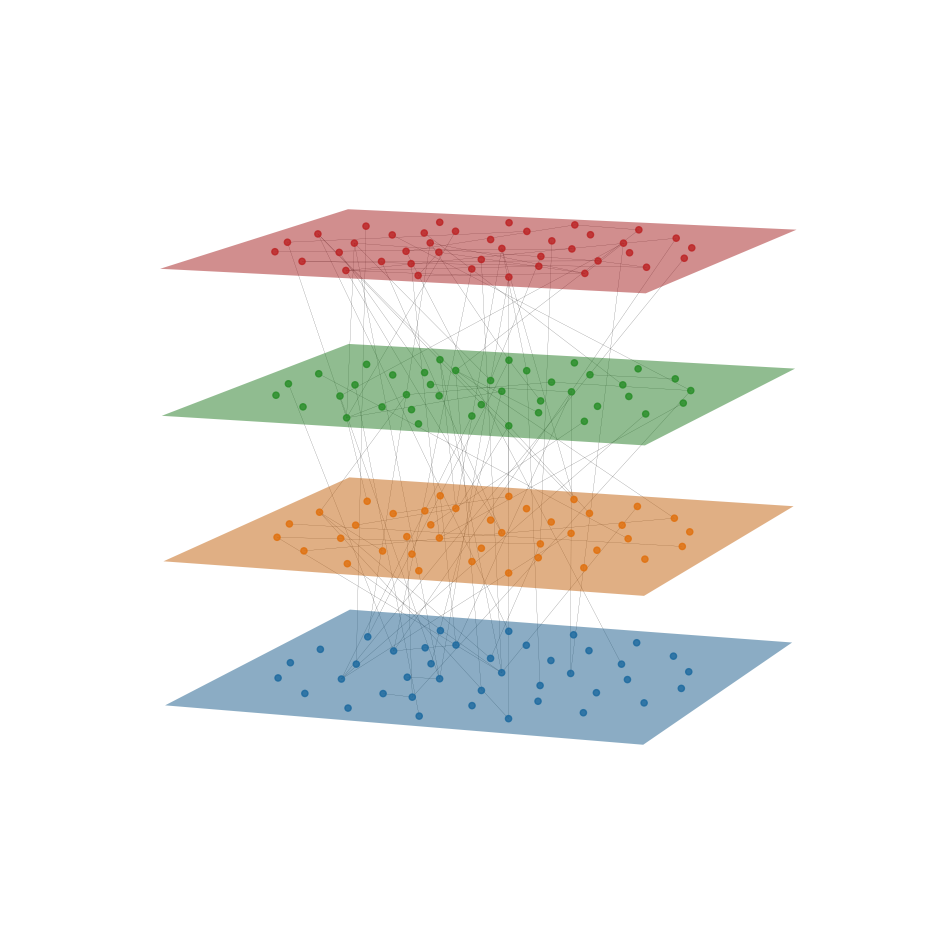

In [246]:



#positions = gt.draw.sfdp_layout(gf_list[pos_idx]).get_2d_array([0,1])

x_width = positions[0].max()-positions[0].min()
y_width = positions[1].max()-positions[1].min()

ax = plt.figure(figsize=(12,15)).add_subplot(projection='3d')
xx, yy = np.meshgrid(np.linspace(positions[0].min()-x_width*0.1, positions[0].max()+x_width*0.1,2), np.linspace(positions[1].min()-y_width*0.1, positions[1].max()+y_width*0.1,2))
X =  xx
Y =  yy

df_filt = df_edg[np.all([np.isin(df_edg["NodeIN"],topnodes),np.isin(df_edg["NodeOUT"],topnodes)], axis=0)]
for i in range(len(nets)):
    #ax.text(positions[0].min()-x_width*0.2, positions[1].max()-y_width*0.2,i, net.virus_list[i])
    ax.scatter(positions[0], positions[1], zs=i, zdir='z', label=str(np.arange(4)[i]), alpha=0.8)
    
    df_filt[np.any([df_filt["NodeIN"]==topnodes[0],df_filt["NodeOUT"]==topnodes[0]], axis=0)]
    Z =  i*np.ones(X.shape)
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, alpha=0.5)

edges = np.array([df_filt["NodeIN"].to_numpy(), df_filt["NodeOUT"].map(topnmap).to_numpy(), df_filt["LayerIN"], df_filt["LayerOUT"]]).T

for e in df_edg.to_numpy():
    ax.plot([positions[0][e[0]], positions[0][e[1]]],[positions[1][e[0]],positions[1][e[1]]] ,zs=[e[2],e[3]], c="k", lw=0.1)
    
    
ax.set_xlim(positions[0].min()-x_width*0.2, positions[0].max()+x_width*0.2)
ax.set_zlim(0, len(nets)-1)
ax.set_ylim(positions[1].min()-y_width*0.2, positions[1].max()+y_width*0.2)
ax.axis("off")

ax.view_init(elev=10, azim=20)

plt.show()


In [2]:
net = mxp.VirusMultiplex(SamplingForNoco(10, group_dim=4)[9], target_folder=target_folder, virus_metadata=virus_metadata)

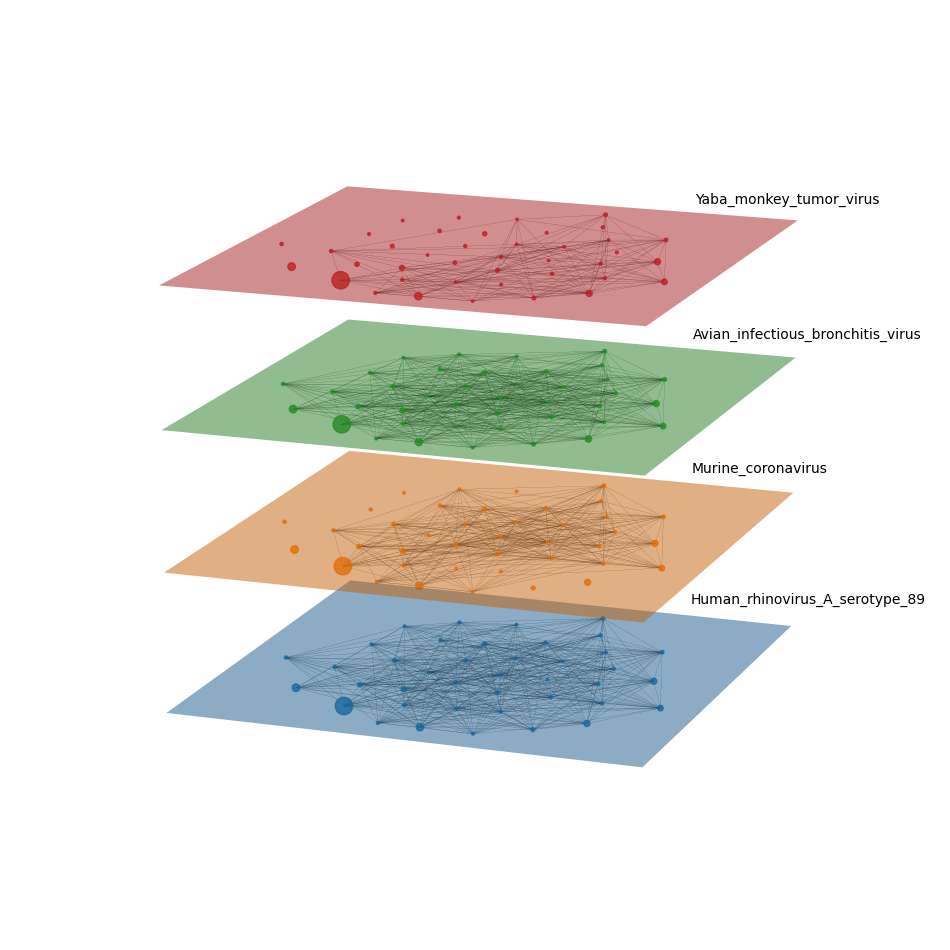

In [10]:
mxp.visualization.Visualize_EdgeColoredNet(net, n_nodes=40, azim=20, elev=15, pos_idx="agg")